In [53]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
import scipy

import cx_rate
import trials
import plotter
import bee_simulator

In [54]:
from cx_spiking.central_complex import CX_SPIKING
from cx_spiking.constants import *
import cx_spiking 

In [55]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500
T_inbound = 1500
T = T_outbound+T_inbound

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=False)


######################################
### RATE BASED CX
######################################
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=T_inbound,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz


Run network outbound for 1500 steps
Starting simulation at t=0. s for a duration of 30. s
3.6327 s (12%) simulated in 10s, estimated 1m 13s remaining.
7.2148 s (24%) simulated in 20s, estimated 1m 3s remaining.
10.6673 s (35%) simulated in 30s, estimated 54s remaining.
14.0801 s (46%) simulated in 40s, estimated 45s remaining.
17.7069 s (59%) simulated in 50s, estimated 35s remaining.
21.2651 s (70%) simulated in 1m 0s, estimated 25s remaining.
24.6755 s (82%) simulated in 1m 10s, estimated 15s remaining.
28.3923 s (94%) simulated in 1m 20s, estimated 5s remaining.
30. s (100%) simulated in 1m 24s


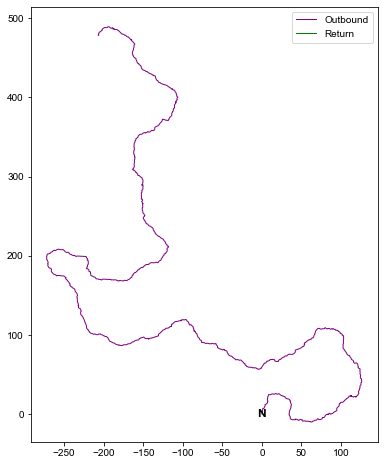

Run network inbound for 1500 steps
Starting simulation at t=30. s for a duration of 30. s
3.4801 s (11%) simulated in 10s, estimated 1m 16s remaining.
7.0681 s (23%) simulated in 20s, estimated 1m 5s remaining.
10.879 s (36%) simulated in 30s, estimated 53s remaining.
14.8935 s (49%) simulated in 40s, estimated 41s remaining.
19.055 s (63%) simulated in 50s, estimated 29s remaining.
23.1237 s (77%) simulated in 1m 0s, estimated 18s remaining.
27.2533 s (90%) simulated in 1m 10s, estimated 7s remaining.
30. s (100%) simulated in 1m 16s


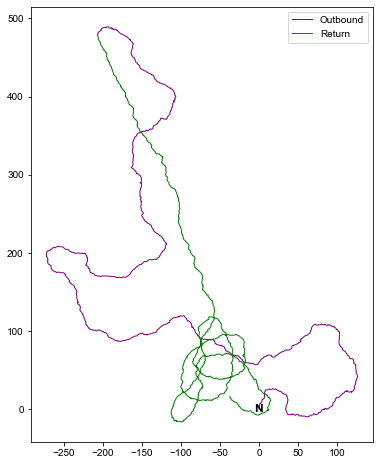

In [57]:
cpu4_method = 1

mem_gain_outbound = 0.05
decay_outbound= 0.025
mem_gain_inbound = 0.05
decay_inbound = 0.033

rotation_factor = 0.1

spiking_cx = CX_SPIKING(eqs, threshold_eqs, reset_eqs,
                        h, v, 
                        mem_gain_outbound, decay_outbound, mem_gain_inbound, decay_inbound,
                        rotation_factor, time_step=20, T_outbound=T_outbound,
                        T_inbound=T_inbound, 
                        headings_method='vonmises', cpu4_method=1,
                        only_tuned_network=True)

spiking_cx.run_outbound()
spiking_cx.plot_bee_position()

spiking_cx.run_inbound(follow_stone_inbound=True)
spiking_cx.plot_bee_position()

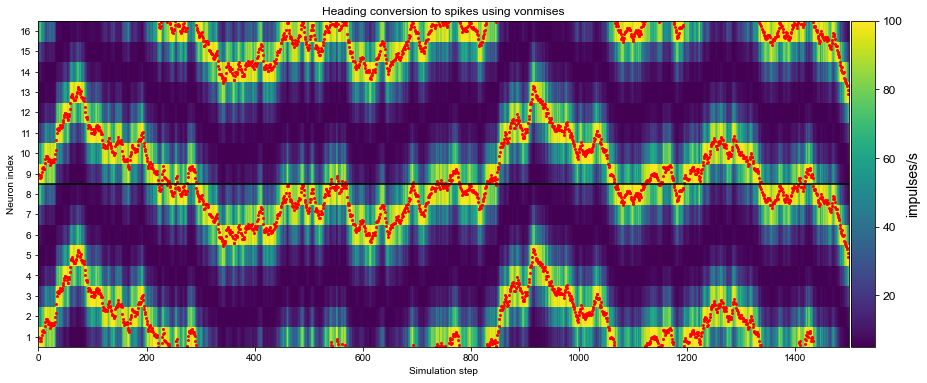

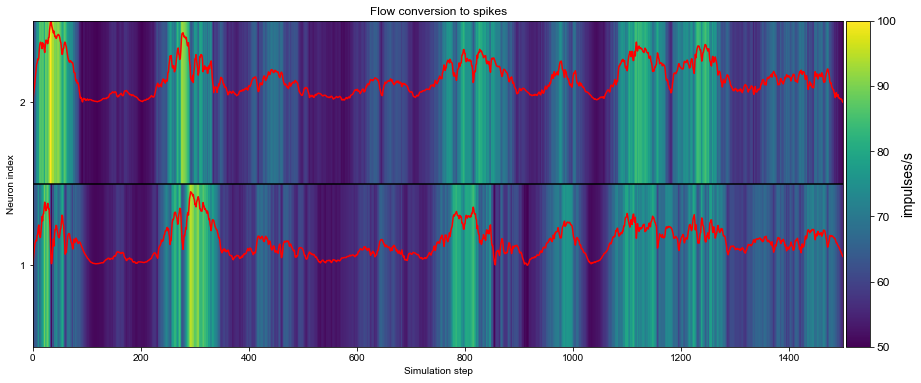

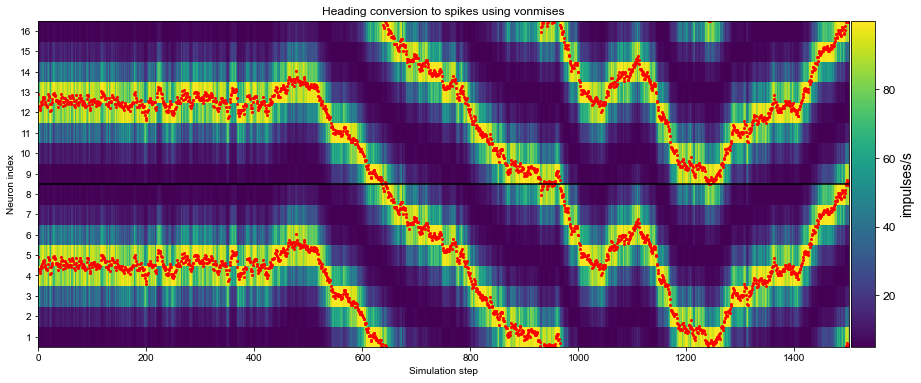

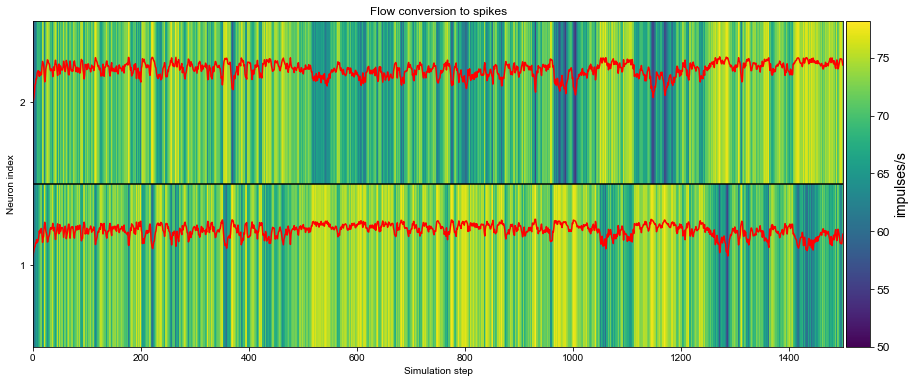

In [59]:
cx_spiking.plotting.plot_inputs_outbound(spiking_cx, h, v)
cx_spiking.plotting.plot_inputs_inbound(spiking_cx, h, v)

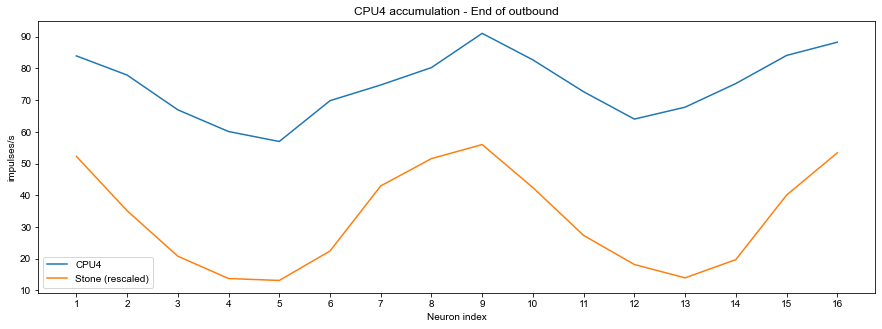

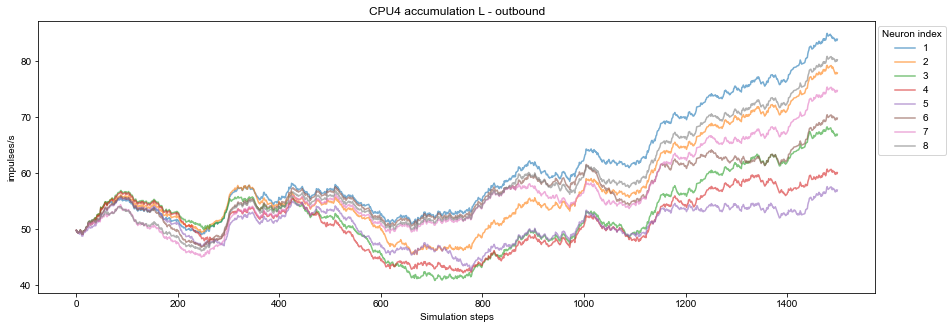

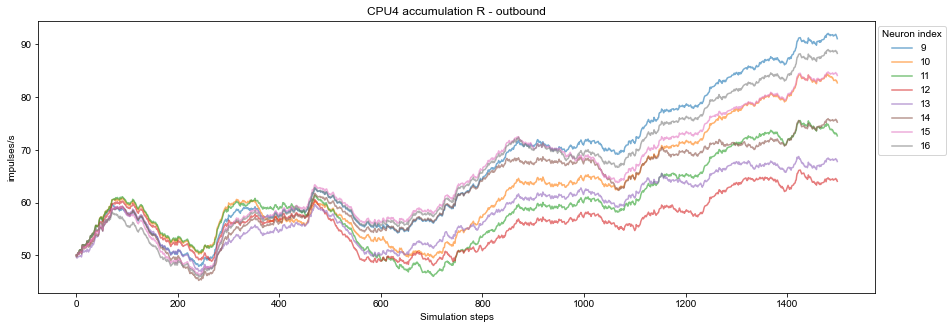

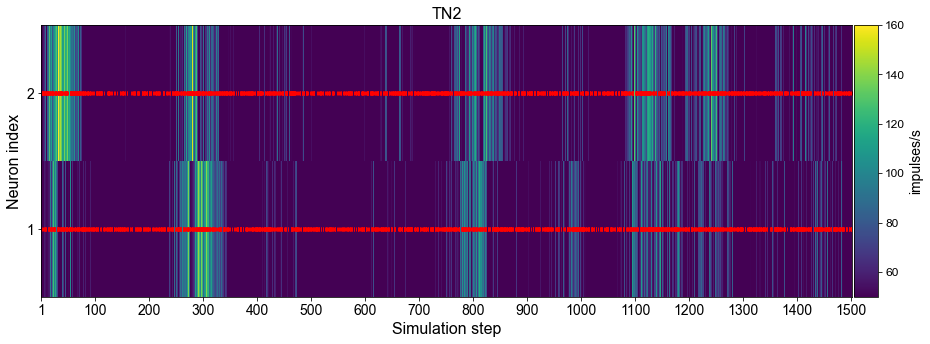

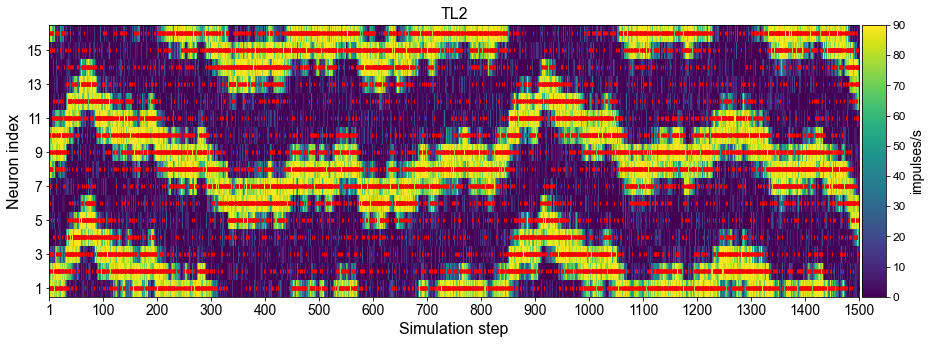

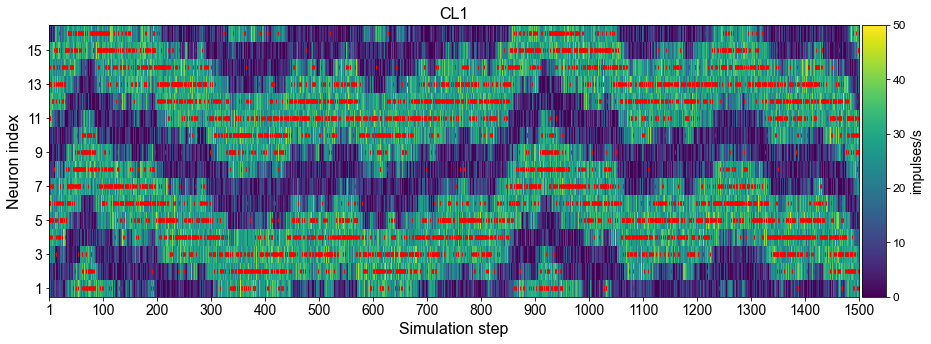

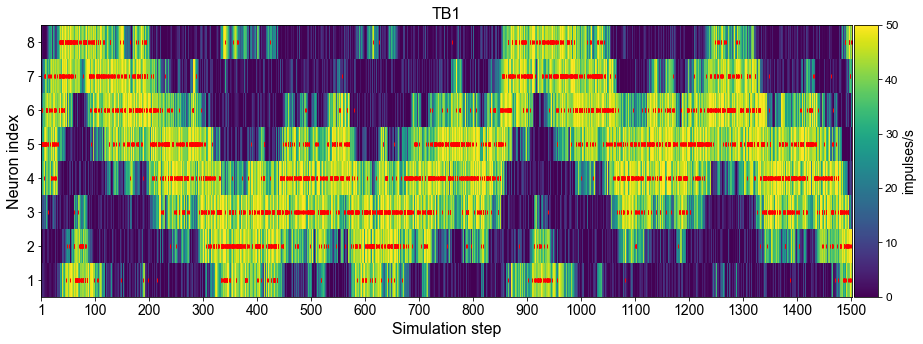

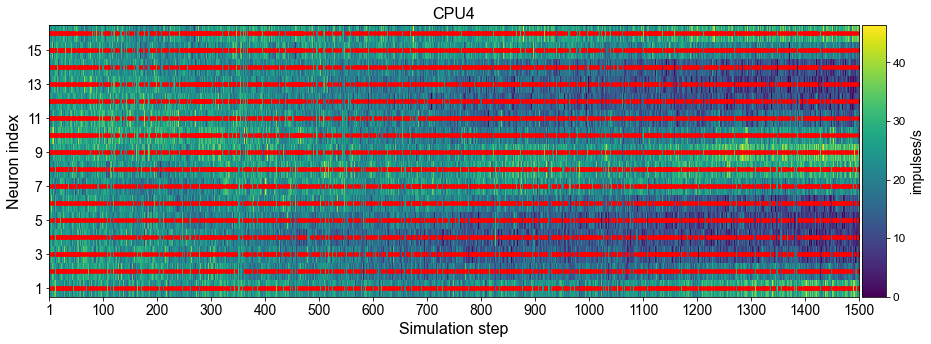

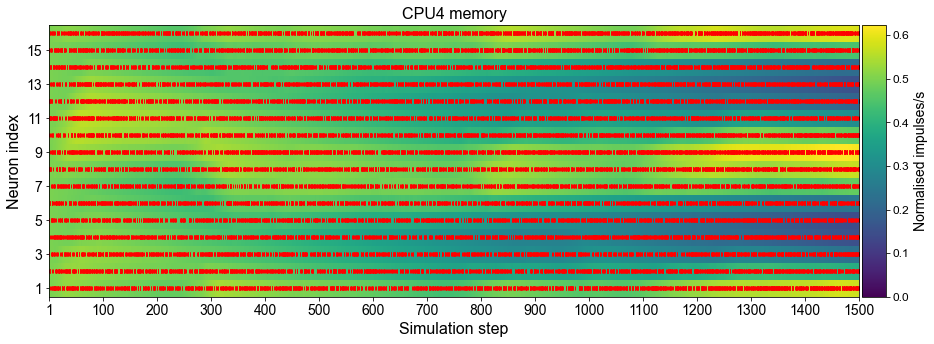

In [60]:
cx_spiking.plotting.plot_memory_outbound(spiking_cx, cx_log)
cx_spiking.plotting.plot_populations_outbound(spiking_cx, cx_log)

In [36]:
def plot_one_paths(spiking_cx, figsize=(8,8), save=False):
    plt.figure(figsize=(10,10))
    plt.text(0, 0, 'N', fontsize=12, fontweight='heavy', color='k', ha='center', va='center')
    plt.plot(spiking_cx.bee_coords[:spiking_cx.T_outbound,0], spiking_cx.bee_coords[:spiking_cx.T_outbound,1], color='purple', lw=2, label='Outbound')
    plt.plot(spiking_cx.bee_coords[spiking_cx.T_outbound:,0], spiking_cx.bee_coords[spiking_cx.T_outbound:,1], color='green', lw=2, label='Inbound')
    plt.legend(fontsize=20)
    plt.xlabel('Distance [steps]', fontsize=22)
    plt.ylabel('Distance [steps]', fontsize=22)
    plt.axis('scaled')
#     plt.tight_layout()
#     if save:
#         plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/spiking_cx_following.pdf'), bbox_inches = "tight")
    plt.show()



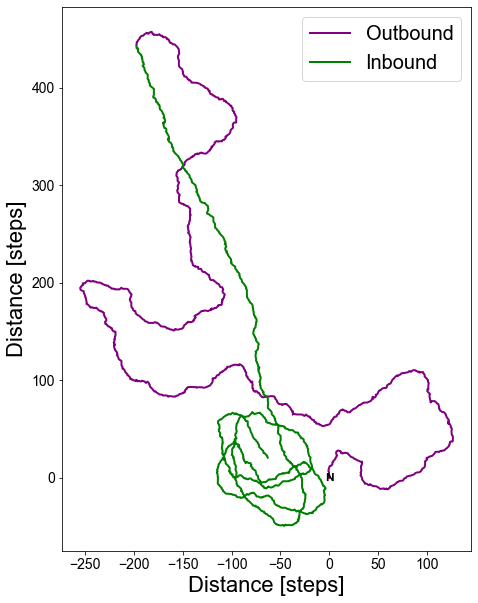

In [37]:
# plot_one_paths(spiking_cx, figsize=(8,8), save=True)

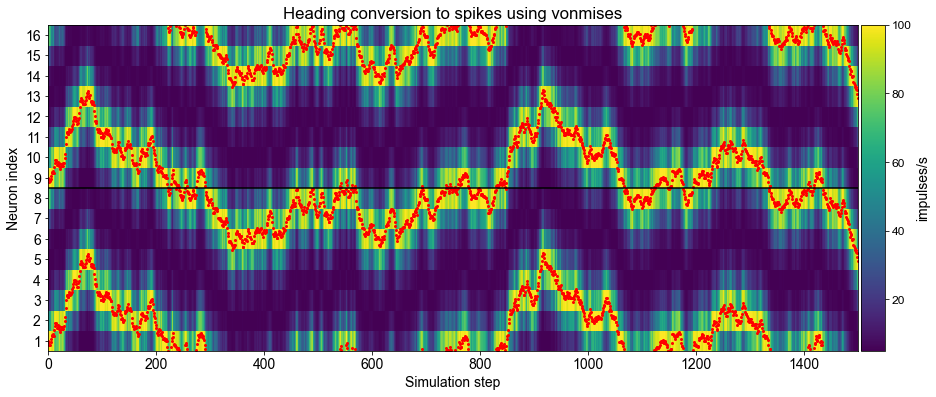

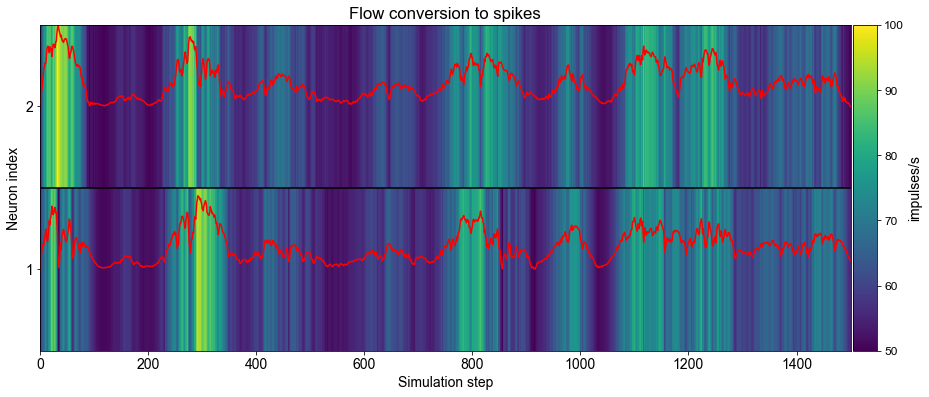

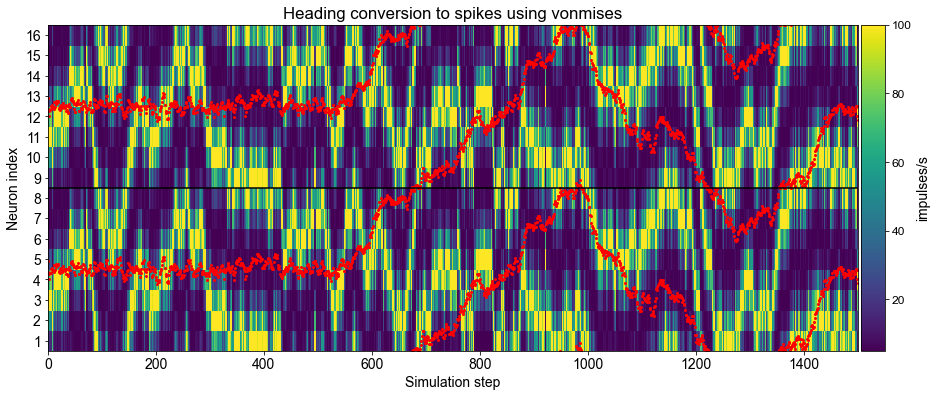

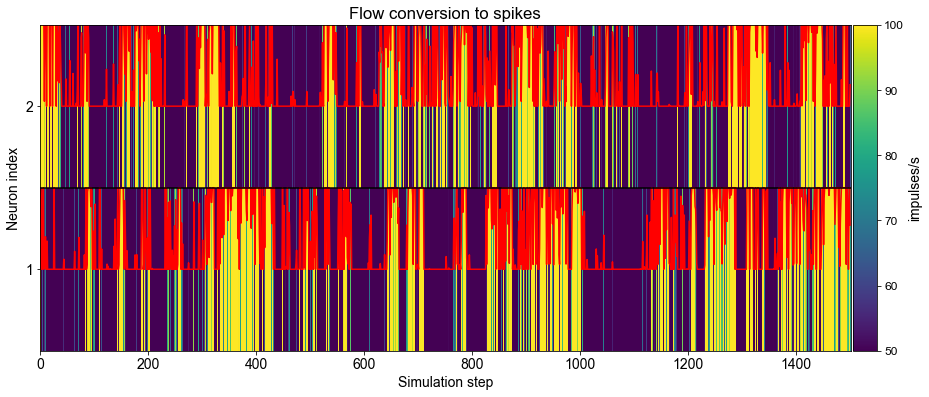

In [58]:
# cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[1:-1,:], 1, spiking_cx.SPM_CPU1A, spiking_cx.time_step,
#                         title='CPU1A',  figsize=(13,4), xlim=[0,spiking_cx.T_outbound+1], fontsize=16,
#                                 savefig_=os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/cpu1a_outbound.pdf'))

# cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[[0,-1],:], 1, spiking_cx.SPM_CPU1B, spiking_cx.time_step, 
#                         title='CPU1B ',  figsize=(13,4), xlim=[0,spiking_cx.T_outbound+1], fontsize=16,
#                                 savefig_=os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/cpu1b_outbound.pdf'))

# motors = cx_spiking.inputs.compute_motors(cx_log.cpu1)
# cx_spiking.plotting.plot_motors_cx_log_spikes(motors/motors.max(), 1, spiking_cx.SPM_MOTOR, spiking_cx.time_step, 
#                         min_rate=motors.min(), 
#                         title='MOTOR',  figsize=(13,4), xlim=[0,spiking_cx.T_outbound+1], fontsize=16,
#                                 savefig_=os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/motor_outbound.pdf'))


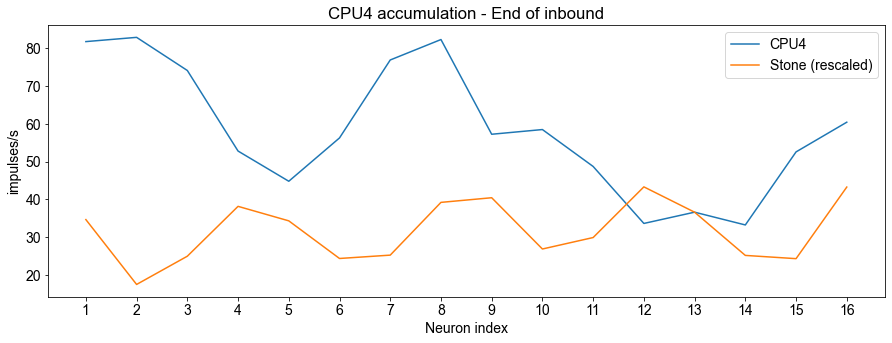

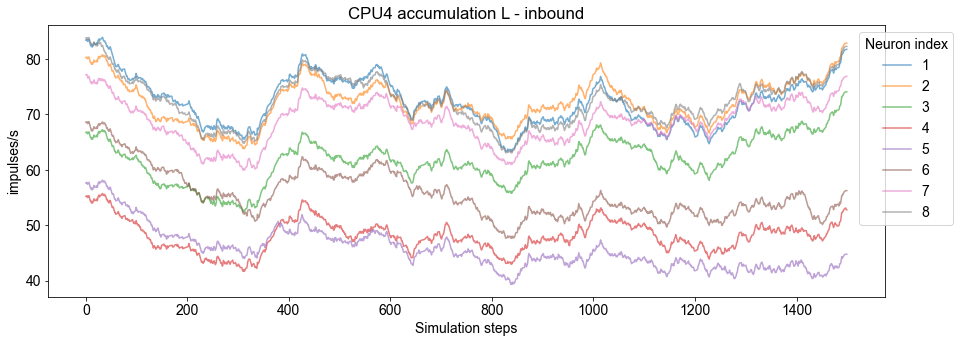

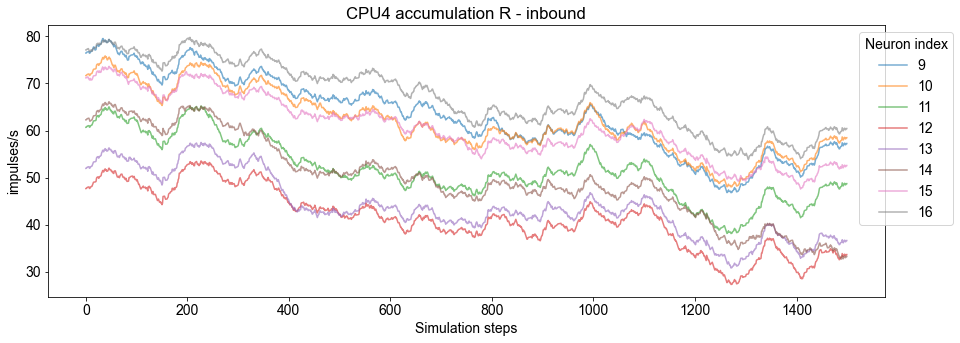

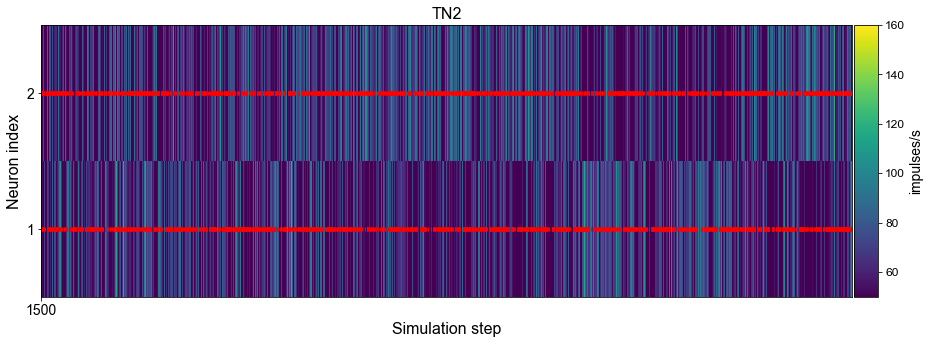

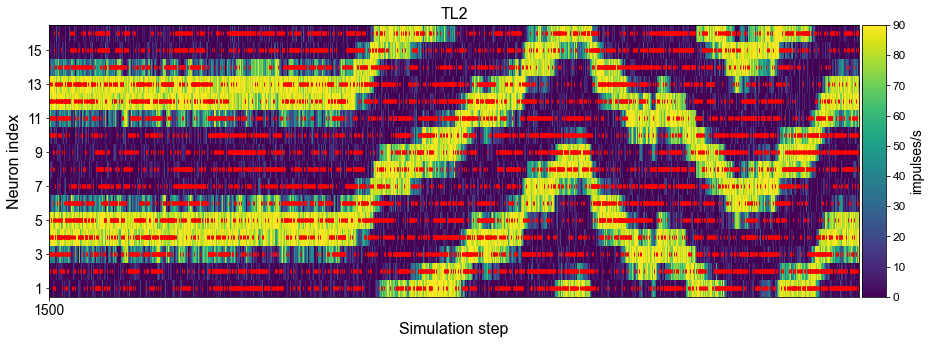

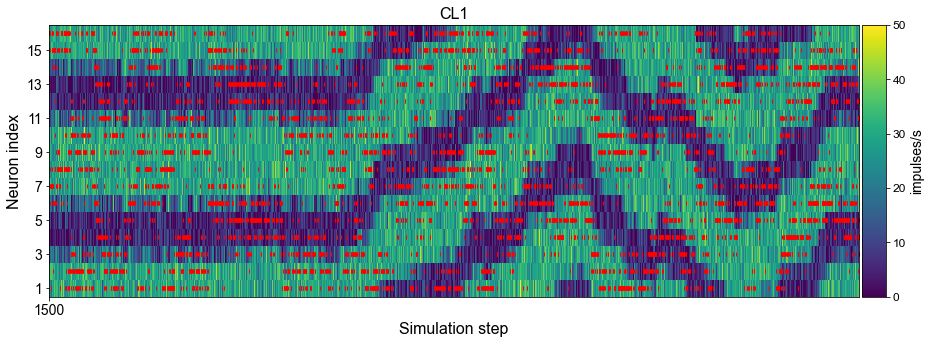

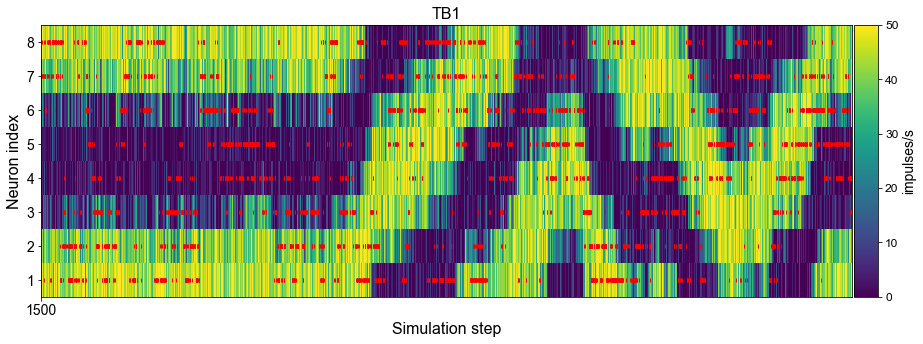

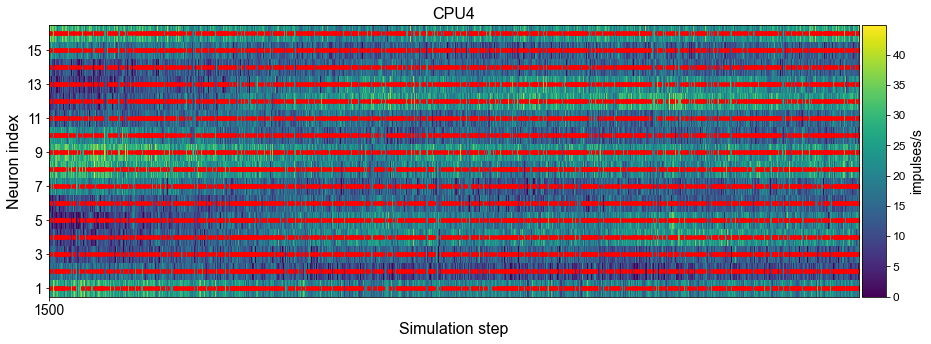

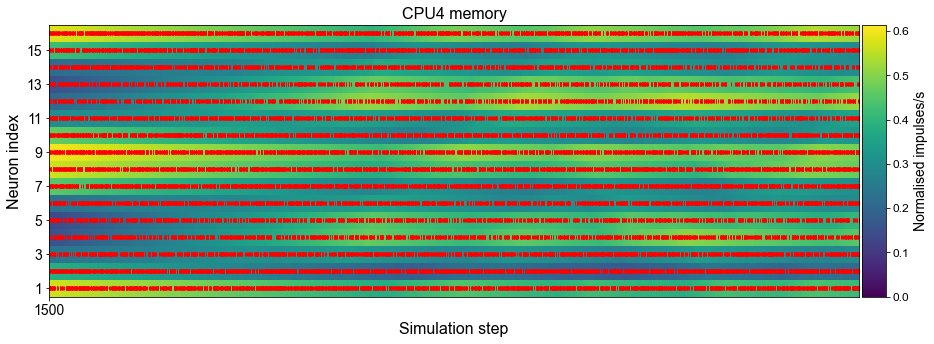

In [25]:
# cx_spiking.plotting.plot_memory_inbound(spiking_cx, cx_log)
# cx_spiking.plotting.plot_populations_inbound(spiking_cx, cx_log)